# Q1 (bad_xml)

In [188]:
import gzip, sys, os, re
from pyspark import SparkContext

import xml.etree.ElementTree as ET

def localpath(path):
    return str(os.path.abspath(os.path.curdir)) + path

def startsWithRow(line):
    return len( re.compile(u'^<row ').findall(line.strip()) ) > 0

def startssEndsProperly(line):
    return len( re.compile(u'(^<row(.*?)\/>)').findall(line.strip()) ) > 0

def startssEndsProperly_Throw_Trash(line):
    return re.compile(u'(^<row(.*?)\/>)').findall(line.strip())[0][0]

def applyParser(line):
    try:
        root = ET.fromstring(re.compile(u'(^<row(.*?)\/>)').findall(line.strip())[0][0].encode('utf-8').strip())
        
        return root
    except:
        return None

In [3]:
sc = SparkContext("local[*]", "temp")

In [5]:
my_input_dir = r'\spark-stats-data\allPosts\part-0*'

lines_1 = sc.textFile(localpath(my_input_dir)).map(startsWithRow).filter(lambda x: x is True).count()
lines_2 = sc.textFile(localpath(my_input_dir)).map(applyParser).filter(lambda x: x is not None).count()
lines_3 = lines_1-lines_2

print "lines with posts: %d" % lines_1
print "readable lines: %d" % lines_2
print "unreadable posts: %d" % lines_3

lines with posts: 109522
readable lines: 108741
unreadable posts: 781


# Q2 (upvote_percentage)

In [55]:
class Vote_El(object): #I get a pickle error
    def __init__(self, PostId, Up, Down, Fav):
        self.PostId = PostId
        self.Up = Up
        self.Down = Down
        self.Fav = Fav
    
def Parse_Vote(line):
    
    root = applyParser(line)
    
    if root is not None:
        
        try:
            PostId = int(root.get('PostId'))
            Up, Down, Fav = 0, 0, 0
        
            var = int(root.get('VoteTypeId'))
            if var == 2: Up += 1
            elif var == 3: Down += 1
            elif var == 5: Fav += 1
        
            #return Vote_El(PostId, Up, Down, Fav)
            return (PostId, Up, Down, Fav)
        
        except:
            return None
        
    else:
        return None

In [89]:
my_input_dir = r'spark-stats-data\allVotes\part-0*'

top_50 = sc.textFile(my_input_dir).map(Parse_Vote).filter(lambda x: x is not None).map(lambda x: (x[0], (x[1], x[2], x[3])) )\
    .reduceByKey(lambda x,y: (x[0]+y[0], x[1]+y[1], x[2]+y[2]) ).map(lambda (key,val): (val[2], (val[0], val[1])) )\
    .reduceByKey(lambda x,y: (x[0]+y[0], x[1]+y[1]) ).map(lambda (key,val): (key, val[0]/float(val[0]+val[1])  ) )\
    .sortByKey(ascending=True).take(50)

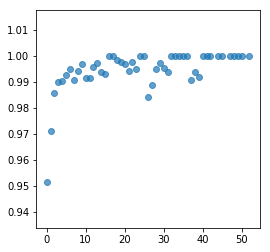

In [105]:
import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

data = np.array([ [el[0], el[1]] for el in top_50 ])

plt.figure(figsize=(4, 4))
plt.scatter( data[:,0],  data[:,1], alpha=0.7)
plt.show()

# Q3  (answer_percentage)   

In [193]:
import numbers

def Get_Ustr_Info(line):
    
    root = applyParser(line)
    
    if root is not None:
        try:    
            UsrId = int(root.get('Id'))
            Reputation = int(root.get('Reputation'))
            return (UsrId, Reputation)
        
        except:
            return None
        
    else:
        return None
    
def Get_Posts_Info(line):
    
    root = applyParser(line)
    
    if root is not None:
        try:
            
            if 'OwnerUserId' in root.attrib:
                UsrId = int(root.attrib['OwnerUserId'])
            else:
                UsrId = -2
            
            quest, answ = 0, 0
            
            var = int(root.get('PostTypeId')) 
            if var == 1: quest += 1
            elif var == 2: answ += 1
            
            return (UsrId, (quest, answ))
        except:
            return None
    else:
        return None
    
def Filter(el):
    try:
        key, val = el
        if isinstance(key, numbers.Number) and isinstance(val[1], numbers.Number) and isinstance(val[0][0], numbers.Number) and isinstance(val[0][1], numbers.Number):
            return True
        else:
            False
    except:
        return False

In [194]:
my_input_Posts = r'spark-stats-data\allPosts\part-0*'
my_input_Users = r'spark-stats-data\allUsers\part-0*'

posts = sc.textFile(my_input_Posts).map(Get_Posts_Info).filter(lambda x: x is not None)
users = sc.textFile(my_input_Users).map(Get_Ustr_Info).filter(lambda x: x is not None)

In [196]:
table = posts.join(users).filter(Filter).map(lambda (key,val): (key, (val[1], val[0][0], val[0][1])) )\
        .reduceByKey(lambda x,y: (x[0], x[1]+y[1], x[2]+y[2]) ).filter(lambda (key,val): val[1]+val[2]!=0 )\
        .map(lambda (key,val): (val[0], val[2]/float(val[1]+val[2])) ).sortByKey(ascending=False)\
        .take(99)

In [195]:
avg_ = posts.map(lambda (k,v): (1, (v[0], v[1])) )\
        .reduceByKey(lambda x,y: (x[0]+y[0], x[1]+y[1]) )\
        .map(lambda (k,v): (v[0], v[1], v[1]/float(v[0]+v[1])) )\
        .collect()

avg_

[(52060, 55304, 0.5151074848180023)]

# Q4 (post_counts)

In [209]:
from lxml import objectify, etree
import re

def parse_Posts_trf_3(line):    
    try:
        strings = re.search('^<row', line.encode('utf-8').strip())
        if strings:
            root = objectify.fromstring(line.encode('utf-8').strip())
            
            if 'OwnerUserId' in root.attrib:
                OwnerUserId = int(root.attrib['OwnerUserId'])
            else:
                OwnerUserId = -2
                
            return (OwnerUserId, 1)
        return None
    except:
        return None

In [211]:
my_input_dir = r'spark-stats-data/allPosts/part-0*'

Own_Id_vs_QA = sc.textFile(localpath(my_input_dir))\
.map(parse_Posts_trf_3)\
.filter(lambda x: x is not None)\
.reduceByKey(lambda va, vb: va+vb)


my_input_dir = r'spark-stats-data/allUsers/part-0*'

Usr_Id_vs_Rep = sc.textFile(localpath(my_input_dir))\
.map(parse_User_Record_trf_1)\
.filter(lambda x: x is not None)


Usr_Id_vs_Rep_vs_QA = Usr_Id_vs_Rep.join(Own_Id_vs_QA)\
.map(lambda (usr_id,(rep,qa)): (qa, (rep,1)) )\
.reduceByKey(lambda va, vb: (va[0]+vb[0], va[1]+vb[1]))\
.map(lambda (qa, (rep_sum, counts)):  (qa, float(rep_sum)/counts) )\
.sortBy(lambda (qa, avg_rep): qa, ascending=False)\
.collect()

q4_res = Usr_Id_vs_Rep_vs_QA[:100]

## Q5 (quick_answers)
        Id
        PostTypeId
          - 1: Question
          - 2: Answer
       - ParentID (only present if PostTypeId is 2)
       - AcceptedAnswerId (only present if PostTypeId is 1)
       - CreationDate
       
questoins: (Q_id, acc_answer_id, creation_date)  
answer:    (A_id, ParentID, creation_date  )

In [213]:
from lxml import objectify, etree
import re
from datetime import datetime, timedelta

def parse_Posts_trf_2(line):    
    try:
        strings = re.search('^<row', line.encode('utf-8').strip())
        if strings:
            root = objectify.fromstring(line.encode('utf-8').strip())
            
            if 'Id' in root.attrib:
                Id = int(root.attrib['Id'])
            else:
                Id = -2
            
            #or just return None if CreationDate is not given
            if 'CreationDate' in root.attrib:
                CreationDate = datetime.strptime(root.attrib['CreationDate'], '%Y-%m-%dT%H:%M:%S.%f').replace(microsecond=0)
            else:
                CreationDate = datetime.datetime(1970, 1, 1, 0, 0, 0)
            
            PostTypeId = int(root.attrib['PostTypeId'])
            if PostTypeId == 2:
                if 'ParentID' in root.attrib:
                    ParentID         = int(root.attrib['ParentID'])
                else:
                    ParentID         = -2
                return (Id, ParentID, CreationDate, 'A')
                
            if PostTypeId == 1:
                if 'AcceptedAnswerId' in root.attrib:
                    AcceptedAnswerId = int(root.attrib['AcceptedAnswerId'])
                else:
                    AcceptedAnswerId = -2
                return (Id, AcceptedAnswerId, CreationDate, 'Q')

            return None
        else:
            return None
    except:
        return None

In [214]:
my_input_dir = r'spark-stats-data/allPosts/part-0*'

q_with_acc_answ = sc.textFile(localpath(my_input_dir))\
.map(parse_Posts_trf_2)\
.filter(lambda x: x is not None)\
.filter(lambda x: x[0]!=-2 and x[1]!=-2 and x[2]!=datetime(1970, 1, 1, 0, 0, 0) and x[3]=='Q')


answ = sc.textFile(localpath(my_input_dir))\
.map(parse_Posts_trf_2)\
.filter(lambda x: x is not None)\
.filter(lambda x: x[0]!=-2 and              x[2]!=datetime(1970, 1, 1, 0, 0, 0) and x[3]=='A')


acc_answ_in_my_set = q_with_acc_answ.map(lambda x: (x[1], x[2]) ).join( answ.map(lambda x: (x[0],x[2]) ) )

quick_acc_answ_in_my_set = acc_answ_in_my_set.filter(lambda x: x[1][1]-x[1][0]<timedelta(0, 10800) )



tot_acc_answ_by_q_hour = acc_answ_in_my_set.map(lambda x: (x[1][0].hour ,1) ).reduceByKey(lambda x, y: x+y).sortByKey().collect()

tot_quick_acc_answ_by_hour = quick_acc_answ_in_my_set.map(lambda x: (x[1][0].hour ,1) ).reduceByKey(lambda x, y: x+y).sortByKey().collect()

In [ ]:
q5_res = []
for el1, el2 in zip(tot_acc_answ_by_q_hour, tot_quick_acc_answ_by_hour):
    q5_res.append(float(el2[1])/el1[1])

# Q6 (quick_answers_full)

In [216]:
my_input_dir = r'spark-stack-data/allPosts/part-0*'

q_with_acc_answ = sc.textFile(localpath(my_input_dir))\
.map(parse_Posts_trf_2)\
.filter(lambda x: x is not None)\
.filter(lambda x: x[0]!=-2 and x[1]!=-2 and x[2]!=datetime(1970, 1, 1, 0, 0, 0) and x[3]=='Q')


answ = sc.textFile(localpath(my_input_dir))\
.map(parse_Posts_trf_2)\
.filter(lambda x: x is not None)\
.filter(lambda x: x[0]!=-2 and              x[2]!=datetime(1970, 1, 1, 0, 0, 0) and x[3]=='A')


# id_acc_answ, cr_date_Q, cr_data_A
acc_answ_in_my_set = q_with_acc_answ.map(lambda x: (x[1], x[2]) ).join( answ.map(lambda x: (x[0],x[2]) ) )

# id_acc_answ, cr_date_Q, cr_data_A
quick_acc_answ_in_my_set = acc_answ_in_my_set.filter(lambda x: x[1][1]-x[1][0]<timedelta(0, 10800) )



tot_acc_answ_by_q_hour = acc_answ_in_my_set.map(lambda x: (x[1][0].hour ,1) ).reduceByKey(lambda x, y: x+y).sortByKey().collect()

tot_quick_acc_answ_by_hour = quick_acc_answ_in_my_set.map(lambda x: (x[1][0].hour ,1) ).reduceByKey(lambda x, y: x+y).sortByKey().collect()

In [223]:
q6_res = []
for el1, el2 in zip(tot_acc_answ_by_q_hour, tot_quick_acc_answ_by_hour):
    q6_res.append(float(el2[1])/el1[1])

# Q7 (identify_veterans)
posts 100-150 days after account creation date -> (active vs inactive users)  
get first question of veterans and users  
for both groups: average the score, views, number of answers and number of favorites of the users' first question  


In [3]:
# PostTypeId: 1-Q, 2-A get something only if PostTypeId == 1
from lxml import objectify, etree
import re
from datetime import datetime, timedelta


def parse_User_Record_trf_2(line):
    try:
        strings = re.search(r'^<row', line.strip().encode('utf-8'))
        if strings:
            root = objectify.fromstring(line.strip().encode('utf-8'))
        
            if 'Id' in root.attrib: Id = int(root.attrib['Id'])
            else: Id = -2
    
            if 'CreationDate' in root.attrib: CreationDate = datetime.strptime(root.attrib['CreationDate'], '%Y-%m-%dT%H:%M:%S.%f').replace(microsecond=0)
            else: CreationDate = datetime.datetime(1970, 1, 1, 0, 0, 0)
        
            return (Id, CreationDate)
        return None
    except:
        return None
    
def parse_Posts_trf_4(line):
    try:
        strings = re.search(r'^<row', line.strip().encode('utf-8'))
        if strings:
            root = objectify.fromstring(line.strip().encode('utf-8'))
            
            if 'OwnerUserId' in root.attrib: OwnerUserId = int(root.attrib['OwnerUserId'])
            else: OwnerUserId = -2
            
            if 'PostTypeId' in root.attrib: PostTypeId = int(root.attrib['PostTypeId'])
            else: PostTypeId = -2
            
            if 'CreationDate' in root.attrib: CreationDate = datetime.strptime(root.attrib['CreationDate'], '%Y-%m-%dT%H:%M:%S.%f').replace(microsecond=0)
            else: CreationDate = datetime.datetime(1970, 1, 1, 0, 0, 0)
            
            if 'Score' in root.attrib: Score = int(root.attrib['Score'])
            else: Score = 0 #-999999
            
            if 'ViewCount' in root.attrib: ViewCount = int(root.attrib['ViewCount'])
            else: ViewCount = 0 #-2
            
            if 'AnswerCount' in root.attrib: AnswerCount = int(root.attrib['AnswerCount'])
            else: AnswerCount = 0 #-2
            
            if 'FavoriteCount' in root.attrib: FavoriteCount = int(root.attrib['FavoriteCount'])
            else: FavoriteCount = 0 #-2
            
            return (OwnerUserId, PostTypeId, CreationDate, Score, ViewCount, AnswerCount, FavoriteCount)
            
        return None
    except:
        return None

In [317]:
my_input_dir = r'spark-stats-data/allUsers/part-0*'
Usr_Id_vs_Cr_date = sc.textFile(localpath(my_input_dir)).map(parse_User_Record_trf_2).filter(lambda x: x is not None and x[1]!=datetime(1970, 1, 1, 0, 0, 0))


my_input_dir = r'spark-stats-data/allPosts/part-0*'
all_posts = sc.textFile(localpath(my_input_dir)).map(parse_Posts_trf_4).filter(lambda x: x is not None and x[2]!=datetime(1970, 1, 1, 0, 0, 0))


first_q_by_usr = sc.textFile(localpath(my_input_dir)).map(parse_Posts_trf_4)\
.filter(lambda x: x is not None and x[0]!=-2 and x[1]==1 and x[2]!=datetime(1970, 1, 1, 0, 0, 0) and x[3]!=-999999 and x[4]!=-2 and x[5]!=-2 and x[6]!=-2 )\
.map(lambda x: (x[0], (x[1],x[2],x[3],x[4],x[5],x[6]) ))\
.reduceByKey(lambda x, y: x if x[1]<y[1] else y )


act_usr = Usr_Id_vs_Cr_date.join(  all_posts.map(lambda x: (x[0], x[2]))  )\
.map(lambda x: (x[0], 1) if timedelta(100, 0)<x[1][1]-x[1][0]<timedelta(150, 0) else (x[0], 0) )\
.reduceByKey(lambda x, y: x+y)\
.filter(lambda x: x[1]>0)\
.map(lambda x: (x[0],1) )


inact_usr = Usr_Id_vs_Cr_date.join(  all_posts.map(lambda x: (x[0], x[2]))  )\
.map(lambda x: (x[0], 1) if timedelta(100, 0)<x[1][1]-x[1][0]<timedelta(150, 0) else (x[0], 0) )\
.reduceByKey(lambda x, y: x+y)\
.filter(lambda x: x[1]==0)\
.map(lambda x: (x[0],1) )


act_usr_first_q_stats = act_usr.join(first_q_by_usr)\
.map(lambda x: (x[1][1][2],x[1][1][3],x[1][1][4],x[1][1][5],1))\
.reduce(lambda x, y: (x[0]+y[0], x[1]+y[1], x[2]+y[2], x[3]+y[3], x[4]+y[4]) )

inact_usr_first_q_stats = inact_usr.join(first_q_by_usr)\
.map(lambda x: (x[1][1][2],x[1][1][3],x[1][1][4],x[1][1][5],1))\
.reduce(lambda x, y: (x[0]+y[0], x[1]+y[1], x[2]+y[2], x[3]+y[3], x[4]+y[4]) )

In [ ]:
def identify_veterans():
    return {"vet_score": float(act_usr_first_q_stats[0])/act_usr_first_q_stats[4],
            "vet_views": float(act_usr_first_q_stats[1])/act_usr_first_q_stats[4],
            "vet_answers": float(act_usr_first_q_stats[2])/act_usr_first_q_stats[4],
            "vet_favorites": float(act_usr_first_q_stats[3])/act_usr_first_q_stats[4],
            "brief_score": float(inact_usr_first_q_stats[0])/inact_usr_first_q_stats[4],
            "brief_views": float(inact_usr_first_q_stats[1])/inact_usr_first_q_stats[4],
            "brief_answers": float(inact_usr_first_q_stats[2])/inact_usr_first_q_stats[4],
            "brief_favorites": float(inact_usr_first_q_stats[3])/inact_usr_first_q_stats[4]
           }

# Q8 (identify_veterans_full)

In [ ]:
my_input_dir = r'spark-stack-data/allUsers/part-0*'
Usr_Id_vs_Cr_date = sc.textFile(localpath(my_input_dir)).map(parse_User_Record_trf_2).filter(lambda x: x is not None and x[1]!=datetime(1970, 1, 1, 0, 0, 0))


my_input_dir = r'spark-stack-data/allPosts/part-0*'
all_posts = sc.textFile(localpath(my_input_dir)).map(parse_Posts_trf_4).filter(lambda x: x is not None and x[2]!=datetime(1970, 1, 1, 0, 0, 0))


first_q_by_usr = sc.textFile(localpath(my_input_dir)).map(parse_Posts_trf_4)\
.filter(lambda x: x is not None and x[0]!=-2 and x[1]==1 and x[2]!=datetime(1970, 1, 1, 0, 0, 0) and x[3]!=-999999 and x[4]!=-2 and x[5]!=-2 and x[6]!=-2 )\
.map(lambda x: (x[0], (x[1],x[2],x[3],x[4],x[5],x[6]) ))\
.reduceByKey(lambda x, y: x if x[1]<y[1] else y )


act_usr = Usr_Id_vs_Cr_date.join(  all_posts.map(lambda x: (x[0], x[2]))  )\
.map(lambda x: (x[0], 1) if timedelta(100, 0)<x[1][1]-x[1][0]<timedelta(150, 0) else (x[0], 0) )\
.reduceByKey(lambda x, y: x+y)\
.filter(lambda x: x[1]>0)\
.map(lambda x: (x[0],1) )


inact_usr = Usr_Id_vs_Cr_date.join(  all_posts.map(lambda x: (x[0], x[2]))  )\
.map(lambda x: (x[0], 1) if timedelta(100, 0)<x[1][1]-x[1][0]<timedelta(150, 0) else (x[0], 0) )\
.reduceByKey(lambda x, y: x+y)\
.filter(lambda x: x[1]==0)\
.map(lambda x: (x[0],1) )


act_usr_first_q_stats = act_usr.join(first_q_by_usr)\
.map(lambda x: (x[1][1][2],x[1][1][3],x[1][1][4],x[1][1][5],1))\
.reduce(lambda x, y: (x[0]+y[0], x[1]+y[1], x[2]+y[2], x[3]+y[3], x[4]+y[4]) )

inact_usr_first_q_stats = inact_usr.join(first_q_by_usr)\
.map(lambda x: (x[1][1][2],x[1][1][3],x[1][1][4],x[1][1][5],1))\
.reduce(lambda x, y: (x[0]+y[0], x[1]+y[1], x[2]+y[2], x[3]+y[3], x[4]+y[4]) )

In [ ]:
def identify_veterans_full():
    return {"vet_score": float(act_usr_first_q_stats[0])/act_usr_first_q_stats[4],
            "vet_views": float(act_usr_first_q_stats[1])/act_usr_first_q_stats[4],
            "vet_answers": float(act_usr_first_q_stats[2])/act_usr_first_q_stats[4],
            "vet_favorites": float(act_usr_first_q_stats[3])/act_usr_first_q_stats[4],
            "brief_score": float(inact_usr_first_q_stats[0])/inact_usr_first_q_stats[4],
            "brief_views": float(inact_usr_first_q_stats[1])/inact_usr_first_q_stats[4],
            "brief_answers": float(inact_usr_first_q_stats[2])/inact_usr_first_q_stats[4],
            "brief_favorites": float(inact_usr_first_q_stats[3])/inact_usr_first_q_stats[4]
           }

# Q9 (word2vec)
using the tags of each StackExchange post as documents  
Spark ML's implementation of Word2Vec (this will require using DataFrames)  
list of the top 25 closest synonyms to "ggplot2" and their similarity score in tuple format ("string", number)  
dimensionality of the vector space should be 100. The random seed should be 42L.

In [1]:
from pyspark import SparkContext
sc = SparkContext("local[*]", "temp")

import os
def localpath(path):
    return 'file://' + str(os.path.abspath(os.path.curdir)) + '/' + path

# needed to convert RDDs into DataFrames
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

from pyspark.ml.feature import Word2Vec

In [11]:
from lxml import objectify, etree
import re
from datetime import datetime, timedelta

def parse_Posts_trf_5(line):    
    try:
        strings = re.search('^<row', line.encode('utf-8').strip())
        if strings:
            root = objectify.fromstring(line.encode('utf-8').strip())
            Tags = re.compile('\w+').findall( root.attrib['Tags'] )
            return (Tags)
        else:
            return None
    except:
        return None

In [ ]:
my_input_dir = r'spark-stack-data/allPosts/part*'

my_tags = sc.textFile(localpath(my_input_dir)).map(parse_Posts_trf_5).filter(lambda x: x is not None).map(lambda x: (x,1)).toDF(['tags', 'some_var'])
w2v = Word2Vec(vectorSize=100, seed=42, inputCol='tags', outputCol='vectors')#, minCount=1
my_model = w2v.fit(my_tags)

vectors = my_model.getVectors().rdd.map(lambda x: (x.word, x.vector))

n_synonyms = 25
my_synonyms = my_model.findSynonyms("ggplot2", n_synonyms).select("word", "similarity").take(n_synonyms)
Q9_res = []
for i in range(n_synonyms):
    Q9_res.append( (my_synonyms[i][0], my_synonyms[i][1]) )

In [197]:
sc.stop()